In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth

from itertools import combinations
from collections import Counter

import matplotlib.colors as mcolors

%matplotlib inline

In [2]:
df = pd.read_csv('data/Bakery sales.csv')

## Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     234005 non-null  int64  
 1   date           234005 non-null  object 
 2   time           234005 non-null  object 
 3   ticket_number  234005 non-null  float64
 4   article        234005 non-null  object 
 5   Quantity       234005 non-null  float64
 6   unit_price     234005 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 12.5+ MB


In [4]:
df.loc[:,'Unnamed: 0']

0              0
1              1
2              4
3              5
4              8
           ...  
234000    511387
234001    511388
234002    511389
234003    511392
234004    511395
Name: Unnamed: 0, Length: 234005, dtype: int64

There is a column named "UnnamedL 0" that will not be useful for the analysis so it will be removed

In [5]:
df = df.drop(columns = 'Unnamed: 0')

### Formatting columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           234005 non-null  object 
 1   time           234005 non-null  object 
 2   ticket_number  234005 non-null  float64
 3   article        234005 non-null  object 
 4   Quantity       234005 non-null  float64
 5   unit_price     234005 non-null  object 
dtypes: float64(2), object(4)
memory usage: 10.7+ MB


In [7]:
df['unit_price']

0         0,90 €
1         1,20 €
2         1,20 €
3         1,15 €
4         1,20 €
           ...  
234000    0,15 €
234001    1,20 €
234002    0,15 €
234003    1,30 €
234004    1,30 €
Name: unit_price, Length: 234005, dtype: object

The column "unit_price" is of object type, a string, so it has be casted to be casted as a float. The first step is to remove the whitespace, the Euro € symbol, and replace the commas for the decimal places with a dot.

In [8]:
def convert_currency_format(value):
    value = value.replace('€', '')
    value = value.replace(' ', '')
    value = value.replace(',', '.')
    return float(value)

In [9]:
df['unit_price'] = df['unit_price'].astype(str)
df['unit_price'] = df['unit_price'].apply(convert_currency_format)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           234005 non-null  object 
 1   time           234005 non-null  object 
 2   ticket_number  234005 non-null  float64
 3   article        234005 non-null  object 
 4   Quantity       234005 non-null  float64
 5   unit_price     234005 non-null  float64
dtypes: float64(3), object(3)
memory usage: 10.7+ MB


**Renaming 'Quantity' column to 'quantity'**

In [11]:
df = df.rename(columns={'Quantity': 'quantity'})

In [12]:
df.head()

,date,time,ticket_number,article,quantity,unit_price
0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,0.90
1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,1.20
2,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,1.20
3,2021-01-02,09:14,150041.0,PAIN,1.0,1.15
4,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,1.20


#### Converting 'date' and 'time' to the appropiate data type, and creating a new 'datetime' column

In [13]:
df['date'] = df['date'].astype(str)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           234005 non-null  datetime64[ns]
 1   time           234005 non-null  object        
 2   ticket_number  234005 non-null  float64       
 3   article        234005 non-null  object        
 4   quantity       234005 non-null  float64       
 5   unit_price     234005 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 10.7+ MB


In [15]:
df.head()

,date,time,ticket_number,article,quantity,unit_price
0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,0.90
1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,1.20
2,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,1.20
3,2021-01-02,09:14,150041.0,PAIN,1.0,1.15
4,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,1.20


In [16]:
df['time'] = df['time'].astype(str)
df['time'] = df['time'] + ':00'

In [17]:
df['time'] = pd.to_timedelta(df['time'])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype          
---  ------         --------------   -----          
 0   date           234005 non-null  datetime64[ns] 
 1   time           234005 non-null  timedelta64[ns]
 2   ticket_number  234005 non-null  float64        
 3   article        234005 non-null  object         
 4   quantity       234005 non-null  float64        
 5   unit_price     234005 non-null  float64        
dtypes: datetime64[ns](1), float64(3), object(1), timedelta64[ns](1)
memory usage: 10.7+ MB


In [19]:
df['datetime'] = df['date'] + df['time']

In [20]:
df.head()

,date,time,ticket_number,article,quantity,unit_price,datetime
0,2021-01-02,0 days 08:38:00,150040.0,BAGUETTE,1.0,0.90,2021-01-02 08:38:00
1,2021-01-02,0 days 08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,1.20,2021-01-02 08:38:00
2,2021-01-02,0 days 09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,1.20,2021-01-02 09:14:00
3,2021-01-02,0 days 09:14:00,150041.0,PAIN,1.0,1.15,2021-01-02 09:14:00
4,2021-01-02,0 days 09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,2021-01-02 09:25:00


In [21]:
df.describe()

,date,time,ticket_number,quantity,unit_price,datetime
count,234005,234005,234005.000000,234005.000000,234005.000000,234005
mean,2021-11-30 11:33:31.049336576,0 days 11:34:00.873827482,219201.258738,1.538377,1.662195,2021-11-30 23:07:31.923163904
min,2021-01-02 00:00:00,0 days 07:01:00,150040.000000,-200.000000,0.000000,2021-01-02 08:38:00
25%,2021-07-03 00:00:00,0 days 09:42:00,184754.000000,1.000000,1.100000,2021-07-03 11:21:00
50%,2021-11-04 00:00:00,0 days 11:06:00,218807.000000,1.000000,1.200000,2021-11-04 11:56:00
75%,2022-05-31 00:00:00,0 days 12:21:00,253927.000000,2.000000,1.500000,2022-05-31 09:18:00
max,2022-09-30 00:00:00,0 days 20:01:00,288913.000000,200.000000,60.000000,2022-09-30 18:56:00
std,NaN,0 days 02:45:25.077746610,40053.223896,1.289603,1.722720,NaN


The "quantity" column has maximum and minimum values of 200 and -200, so we can suspect there are some extreme values in the column.

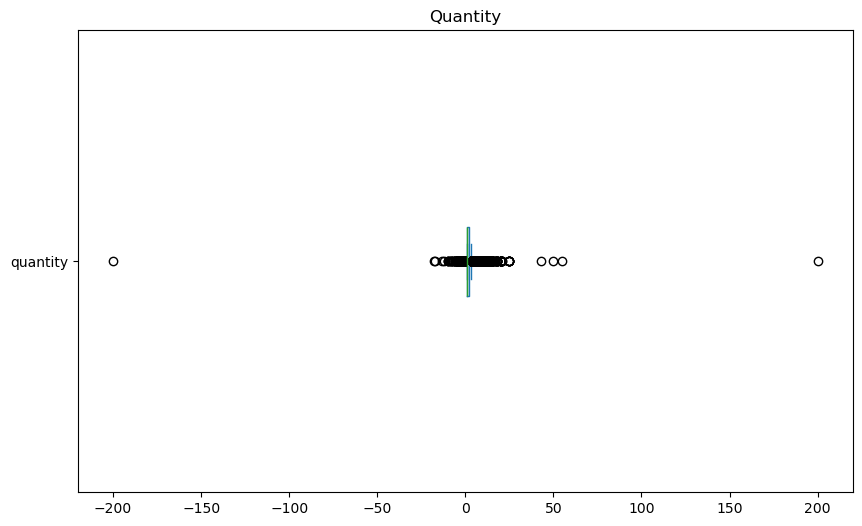

In [22]:
df['quantity'].plot(kind='box', vert=False, figsize=(10,6)).set_title('Quantity')
plt.show()

In [23]:
df[df['quantity'] == 200]

,date,time,ticket_number,article,quantity,unit_price,datetime
50552,2021-06-12,0 days 09:58:00,179931.0,CAFE OU EAU,200.0,1.0,2021-06-12 09:58:00


In [24]:
df[(df['ticket_number'] >= 179931.0) & (df['ticket_number'] < 179933.0)]

,date,time,ticket_number,article,quantity,unit_price,datetime
50552,2021-06-12,0 days 09:58:00,179931.0,CAFE OU EAU,200.0,1.0,2021-06-12 09:58:00
50553,2021-06-12,0 days 09:58:00,179932.0,CAFE OU EAU,-200.0,1.0,2021-06-12 09:58:00


We can observe that this was an error when the quantity was entered, and it was inmediatelly cancelled. These records will be removed from the dataframe.

In [25]:
df = df[(df['quantity'] != 200) & (df['quantity'] != -200)]

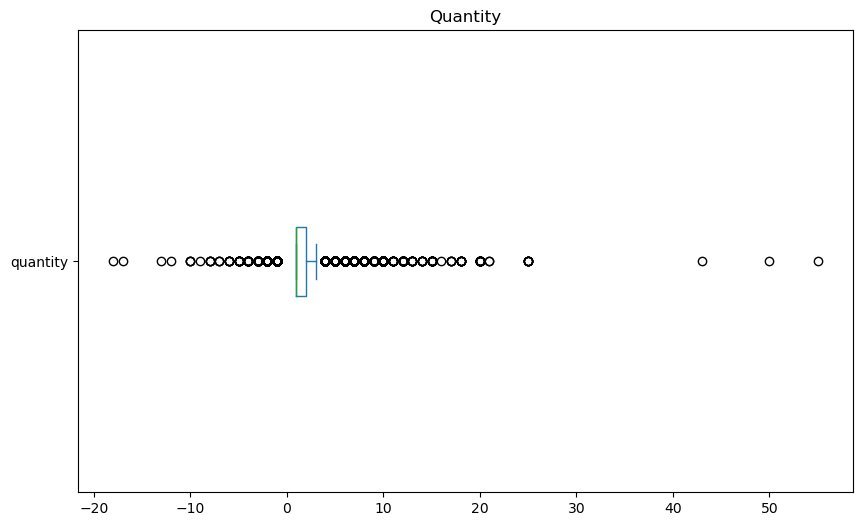

In [26]:
df['quantity'].plot(kind='box', vert=False, figsize=(10,6)).set_title('Quantity')
plt.show()

We still observe values that can be considered outliers, but lets take a closer look first.

In [27]:
df[df['quantity'] > 20]

,date,time,ticket_number,article,quantity,unit_price,datetime
69887,2021-07-23,0 days 11:26:00,191236.0,TARTELETTE,25.0,2.00,2021-07-23 11:26:00
74457,2021-07-30,0 days 17:07:00,193898.0,SEIGLE,25.0,1.80,2021-07-30 17:07:00
74459,2021-07-30,0 days 17:07:00,193898.0,COUPE,25.0,0.15,2021-07-30 17:07:00
89771,2021-08-22,0 days 08:16:00,202518.0,PAIN AU CHOCOLAT,25.0,1.20,2021-08-22 08:16:00
89774,2021-08-22,0 days 08:16:00,202518.0,CROISSANT,25.0,1.10,2021-08-22 08:16:00
111055,2021-10-19,0 days 16:43:00,215345.0,TRADITIONAL BAGUETTE,25.0,1.20,2021-10-19 16:43:00
115245,2021-10-31,0 days 10:42:00,217821.0,TRADITIONAL BAGUETTE,55.0,1.20,2021-10-31 10:42:00
118313,2021-11-08,0 days 10:03:00,219600.0,CAMPAGNE,21.0,1.80,2021-11-08 10:03:00
118314,2021-11-08,0 days 10:03:00,219600.0,COUPE,21.0,0.15,2021-11-08 10:03:00
118315,2021-11-08,0 days 10:03:00,219600.0,BAGUETTE,43.0,0.90,2021-11-08 10:03:00


These seem to be big quantities, but they are reasonable. For example the biggest quantity now is 50, of *PAIN* (bread in English). This could be a customer buying 50 breads for a party or family reunion.

### Checking for duplicates

In [28]:
df.duplicated().sum()

np.int64(1210)

There are 1210 duplicated values

In [29]:
df[df.duplicated(keep=False)]

,date,time,ticket_number,article,quantity,unit_price,datetime
34,2021-01-02,0 days 10:12:00,150061.0,COUPE,1.0,0.15,2021-01-02 10:12:00
36,2021-01-02,0 days 10:12:00,150061.0,COUPE,1.0,0.15,2021-01-02 10:12:00
40,2021-01-02,0 days 10:18:00,150063.0,COUPE,1.0,0.15,2021-01-02 10:18:00
43,2021-01-02,0 days 10:18:00,150063.0,COUPE,1.0,0.15,2021-01-02 10:18:00
218,2021-01-02,0 days 12:23:00,150154.0,TRADITIONAL BAGUETTE,1.0,1.20,2021-01-02 12:23:00
...,...,...,...,...,...,...,...
233675,2022-09-30,0 days 07:49:00,288719.0,COUPE,1.0,0.15,2022-09-30 07:49:00
233743,2022-09-30,0 days 09:45:00,288757.0,COUPE,1.0,0.15,2022-09-30 09:45:00
233744,2022-09-30,0 days 09:45:00,288757.0,COUPE,1.0,0.15,2022-09-30 09:45:00
233927,2022-09-30,0 days 16:02:00,288867.0,COUPE,1.0,0.15,2022-09-30 16:02:00


1210 duplicates were found, these can be the result of wrong entries by the cashiers or just the same products being marked separately in a purchase. 
These rows will not be removed, let's assume these are products marked separately, since this is a pretty usual thing to happen in stores. 

### Addressing negative values in the quantity column

In [30]:
df[df['quantity'] < 0]

,date,time,ticket_number,article,quantity,unit_price,datetime
448,2021-01-03,0 days 10:41:00,150265.0,BAGUETTE,-1.0,0.90,2021-01-03 10:41:00
1162,2021-01-05,0 days 19:00:00,150738.0,SPECIAL BREAD,-1.0,2.40,2021-01-05 19:00:00
1163,2021-01-05,0 days 19:00:00,150738.0,DIVERS PATISSERIE,-1.0,6.00,2021-01-05 19:00:00
1164,2021-01-05,0 days 19:00:00,150738.0,DIVERS BOULANGERIE,-1.0,2.00,2021-01-05 19:00:00
1467,2021-01-08,0 days 11:58:00,150941.0,COUPE,-1.0,0.15,2021-01-08 11:58:00
...,...,...,...,...,...,...,...
233054,2022-09-27,0 days 18:03:00,288312.0,COUPE,-2.0,0.15,2022-09-27 18:03:00
233055,2022-09-27,0 days 18:03:00,288312.0,TRADITIONAL BAGUETTE,-1.0,1.30,2022-09-27 18:03:00
233056,2022-09-27,0 days 18:03:00,288312.0,CEREAL BAGUETTE,-3.0,1.35,2022-09-27 18:03:00
233553,2022-09-29,0 days 11:55:00,288639.0,BOISSON 33CL,-1.0,1.50,2022-09-29 11:55:00


Negative values in the quantity column were found, this can mean that these transactions were refunds and product returns. We can take a closer look to this records with negative quantities, for example the one at 2021-01-05, SPECIAL BREAD, DIVERS PATISSERIE, and DIVERS BOULANGERIE, with the ticket number of 150738.0

In [31]:
#using the date and time to be able to see the transactions made before the one with the negative values
start_time = pd.Timestamp('2021-01-05' + ' 18:40') 
end_time = pd.Timestamp('2021-01-05' + ' 19:00')

df[(df['datetime'] >= start_time) & (df['datetime'] <= end_time)]

,date,time,ticket_number,article,quantity,unit_price,datetime
1156,2021-01-05,0 days 18:49:00,150734.0,BANETTE,2.0,1.05,2021-01-05 18:49:00
1157,2021-01-05,0 days 18:49:00,150735.0,TRADITIONAL BAGUETTE,1.0,1.20,2021-01-05 18:49:00
1158,2021-01-05,0 days 18:51:00,150736.0,TRADITIONAL BAGUETTE,1.0,1.20,2021-01-05 18:51:00
1159,2021-01-05,0 days 18:58:00,150737.0,DIVERS PATISSERIE,1.0,6.00,2021-01-05 18:58:00
1160,2021-01-05,0 days 18:58:00,150737.0,DIVERS BOULANGERIE,1.0,2.00,2021-01-05 18:58:00
1161,2021-01-05,0 days 18:58:00,150737.0,SPECIAL BREAD,1.0,2.40,2021-01-05 18:58:00
1162,2021-01-05,0 days 19:00:00,150738.0,SPECIAL BREAD,-1.0,2.40,2021-01-05 19:00:00
1163,2021-01-05,0 days 19:00:00,150738.0,DIVERS PATISSERIE,-1.0,6.00,2021-01-05 19:00:00
1164,2021-01-05,0 days 19:00:00,150738.0,DIVERS BOULANGERIE,-1.0,2.00,2021-01-05 19:00:00
1165,2021-01-05,0 days 19:00:00,150739.0,DIVERS PATISSERIE,1.0,6.00,2021-01-05 19:00:00


We observe that those same three items were bought a couple of minutes before with the ticket number 150737.0, this shows that these negative numbers may represent, in most cases, returns or cancelled purchases.

**For the purposes of the analysis, the rows with negative amounts will be removed alongside their original transactions since the aim of this project is analyzing the sales.**

#### Removing cancelled purchases

Cancelled purchases or returned prodcuts are going to be those that contain both the **quantity** and **revenue** columns with a negative number, and the previous transaction has those same values in the **quantity** and **revenue** columns but positive. For example:
| ticket_number | quantity | revenue |
|---------------|----------|---------|
|      123      | 4        | 7       |
|      124      | -4       | -7      |

This would be considered a cancelled purchase.

Adding a "revenue" column:

In [32]:
df['revenue'] = df['quantity'] * df['unit_price']

In [33]:
transactions = df.groupby('ticket_number').agg({
    'quantity': 'sum',
    'revenue': 'sum'
}).reset_index()

transactions = transactions.sort_values(by='ticket_number')
transactions

,ticket_number,quantity,revenue
0,150040.0,4.0,4.50
1,150041.0,3.0,3.55
2,150042.0,5.0,6.00
3,150043.0,5.0,5.10
4,150044.0,1.0,1.05
...,...,...,...
136444,288908.0,2.0,2.70
136445,288910.0,1.0,1.30
136446,288911.0,11.0,12.15
136447,288912.0,1.0,1.30


Creating **prev_ticket**, **prev_quantity**, and **prev_revenue** columns and using **shift(1)** to assign them the values of the previous transaction.

In [34]:
transactions['prev_ticket'] = transactions['ticket_number'].shift(1)
transactions['prev_quantity'] = transactions['quantity'].shift(1)
transactions['prev_revenue'] = transactions['revenue'].shift(1)

In [35]:
returns = transactions[transactions['quantity'] < 0]
returns

,ticket_number,quantity,revenue,prev_ticket,prev_quantity,prev_revenue
222,150265.0,-1.0,-0.90,150264.0,1.0,0.90
685,150738.0,-3.0,-10.40,150737.0,3.0,10.40
883,150941.0,-8.0,-8.45,150940.0,8.0,8.45
1211,151280.0,-2.0,-2.65,151279.0,2.0,2.65
1406,151476.0,-1.0,-6.50,151475.0,2.0,1.65
...,...,...,...,...,...,...
133338,285716.0,-3.0,-9.60,285715.0,3.0,9.60
134409,286810.0,-2.0,-2.60,286809.0,2.0,2.60
135514,287953.0,-2.0,-1.80,287952.0,2.0,1.80
135866,288312.0,-10.0,-22.55,288311.0,10.0,22.55


In [36]:
#transactions where the ticket number is not 1 number greater than the ticket number of the previous transaction.
returns[returns['ticket_number'] != (returns['prev_ticket'] + 1)]

,ticket_number,quantity,revenue,prev_ticket,prev_quantity,prev_revenue
15460,165805.0,-2.0,-2.20,165802.0,3.0,3.40
78581,229839.0,-2.0,-3.30,229837.0,2.0,3.30
91566,243142.0,-1.0,-1.25,243140.0,1.0,1.25
96525,248247.0,-2.0,-2.05,248245.0,2.0,2.05
97084,248814.0,-2.0,-2.50,248812.0,2.0,2.50
98073,249831.0,-6.0,-7.20,249829.0,6.0,7.20
104160,256034.0,-3.0,-5.00,256032.0,3.0,5.00
107434,259374.0,-4.0,-7.80,259372.0,1.0,1.25
130481,282809.0,-5.0,-28.15,282807.0,5.0,28.15


**Checking for transactions with negative values where their quantity and revenue do not match with the values of the previous transaction**:

In [37]:
returns[(returns['quantity'] + returns['prev_quantity']) != 0]

,ticket_number,quantity,revenue,prev_ticket,prev_quantity,prev_revenue
1406,151476.0,-1.0,-6.50,151475.0,2.0,1.65
5066,155227.0,-1.0,-6.50,155226.0,2.0,1.65
7016,157215.0,-7.0,-9.50,157214.0,2.0,2.25
9310,159542.0,-3.0,-3.75,159541.0,2.0,8.20
15460,165805.0,-2.0,-2.20,165802.0,3.0,3.40
16683,167048.0,-2.0,-2.10,167047.0,1.0,1.20
16917,167291.0,-1.0,-1.25,167290.0,3.0,5.25
17035,167410.0,-1.0,-6.50,167409.0,4.0,5.65
19980,170400.0,-1.0,-1.05,170399.0,5.0,9.60
23570,174035.0,-9.0,-10.70,174034.0,4.0,4.80


In [38]:
len(returns[(returns['quantity'] + returns['prev_quantity']) != 0])

44

44 of these were found, let's take a closer look selecting one of these at random. Let's check the one with ticket_number 167410.0

In [39]:
df[(df['ticket_number'] == 167410.0) | (df['ticket_number'] == 167409.0) | (df['ticket_number'] == 167411.0)]

,date,time,ticket_number,article,quantity,unit_price,datetime,revenue
29150,2021-04-16,0 days 11:53:00,167409.0,ECLAIR,1.0,2.00,2021-04-16 11:53:00,2.00
29151,2021-04-16,0 days 11:53:00,167409.0,BOULE 400G,1.0,1.50,2021-04-16 11:53:00,1.50
29152,2021-04-16,0 days 11:53:00,167409.0,PARIS BREST,1.0,2.00,2021-04-16 11:53:00,2.00
29153,2021-04-16,0 days 11:53:00,167409.0,COUPE,1.0,0.15,2021-04-16 11:53:00,0.15
29154,2021-04-16,0 days 11:54:00,167410.0,FORMULE SANDWICH,-1.0,6.50,2021-04-16 11:54:00,-6.50
29155,2021-04-16,0 days 11:55:00,167411.0,FORMULE SANDWICH,1.0,6.50,2021-04-16 11:55:00,6.50


We can observe that the previous transaction with ticket_number 167409.0 has different values, but the next one with ticket_number 167411.0 has matching values. This means that for some reason, maybe by mistake, a product was returned and then a purchase of the product was made. The transaction with the negative values will be removed.

In [40]:
returns = returns[(returns['quantity'] + returns['prev_quantity']) == 0]
len(returns)

722

In [41]:
tickets_to_remove = returns['ticket_number'].to_list() + returns['prev_ticket'].to_list()

In [42]:
len(tickets_to_remove)

1444

In [43]:
sales_data = df.copy()

In [44]:
sales_data = sales_data[~sales_data['ticket_number'].isin(tickets_to_remove)]
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231612 entries, 0 to 234004
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype          
---  ------         --------------   -----          
 0   date           231612 non-null  datetime64[ns] 
 1   time           231612 non-null  timedelta64[ns]
 2   ticket_number  231612 non-null  float64        
 3   article        231612 non-null  object         
 4   quantity       231612 non-null  float64        
 5   unit_price     231612 non-null  float64        
 6   datetime       231612 non-null  datetime64[ns] 
 7   revenue        231612 non-null  float64        
dtypes: datetime64[ns](2), float64(4), object(1), timedelta64[ns](1)
memory usage: 15.9+ MB


In [45]:
sales_data.describe()

,date,time,ticket_number,quantity,unit_price,datetime,revenue
count,231612,231612,231612.000000,231612.000000,231612.000000,231612,231612.000000
mean,2021-11-30 03:32:15.878969856,0 days 11:33:46.972436661,219143.005142,1.554272,1.658170,2021-11-30 15:06:02.851406848,2.412097
min,2021-01-02 00:00:00,0 days 07:01:00,150040.000000,-10.000000,0.000000,2021-01-02 08:38:00,-21.000000
25%,2021-07-03 00:00:00,0 days 09:42:00,184696.750000,1.000000,1.100000,2021-07-03 10:08:45,1.200000
50%,2021-11-03 00:00:00,0 days 11:06:00,218546.500000,1.000000,1.200000,2021-11-03 10:09:30,1.600000
75%,2022-05-31 00:00:00,0 days 12:21:00,254001.250000,2.000000,1.500000,2022-05-31 11:28:00,2.600000
max,2022-09-30 00:00:00,0 days 20:01:00,288913.000000,55.000000,60.000000,2022-09-30 18:56:00,121.000000
std,NaN,0 days 02:45:15.531058639,40078.296728,1.126488,1.715539,NaN,2.532546


In [46]:
sales_data[sales_data['quantity'] < 0]

,date,time,ticket_number,article,quantity,unit_price,datetime,revenue
1845,2021-01-09,0 days 13:23:00,151163.0,FORMULE SANDWICH,-1.0,6.50,2021-01-09 13:23:00,-6.50
2351,2021-01-11,0 days 12:31:00,151476.0,FORMULE SANDWICH,-1.0,6.50,2021-01-11 12:31:00,-6.50
8463,2021-02-09,0 days 13:41:00,155227.0,FORMULE SANDWICH,-1.0,6.50,2021-02-09 13:41:00,-6.50
11892,2021-02-23,0 days 09:25:00,157215.0,CROISSANT,-1.0,1.10,2021-02-23 09:25:00,-1.10
11893,2021-02-23,0 days 09:25:00,157215.0,PAIN CHOCO AMANDES,-2.0,1.50,2021-02-23 09:25:00,-3.00
...,...,...,...,...,...,...,...,...
218187,2022-08-19,0 days 16:13:00,279309.0,COUPE,-1.0,0.15,2022-08-19 16:13:00,-0.15
218188,2022-08-19,0 days 16:13:00,279309.0,VIK BREAD,-1.0,2.70,2022-08-19 16:13:00,-2.70
218189,2022-08-19,0 days 16:13:00,279309.0,PAIN CHOCO AMANDES,-2.0,1.70,2022-08-19 16:13:00,-3.40
226377,2022-09-06,0 days 09:51:00,284218.0,BAGUETTE,-1.0,1.00,2022-09-06 09:51:00,-1.00


There are still 98 transactions with negative values in **quantity** and **revenue**, which may belong to the cases we observed before. Since they do not represent a big percentage of the dataset and are not going to be useful for the purposes of this project, they will me removed 

In [47]:
sales_data = sales_data[sales_data['quantity'] > 0]
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231514 entries, 0 to 234004
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype          
---  ------         --------------   -----          
 0   date           231514 non-null  datetime64[ns] 
 1   time           231514 non-null  timedelta64[ns]
 2   ticket_number  231514 non-null  float64        
 3   article        231514 non-null  object         
 4   quantity       231514 non-null  float64        
 5   unit_price     231514 non-null  float64        
 6   datetime       231514 non-null  datetime64[ns] 
 7   revenue        231514 non-null  float64        
dtypes: datetime64[ns](2), float64(4), object(1), timedelta64[ns](1)
memory usage: 15.9+ MB


In [48]:
sales_data.describe()

,date,time,ticket_number,quantity,unit_price,datetime,revenue
count,231514,231514,231514.000000,231514.000000,231514.000000,231514,231514.000000
mean,2021-11-30 03:26:25.241497088,0 days 11:33:46.030304862,219142.868479,1.555664,1.657530,2021-11-30 15:00:11.271801856,2.414959
min,2021-01-02 00:00:00,0 days 07:01:00,150040.000000,1.000000,0.000000,2021-01-02 08:38:00,0.000000
25%,2021-07-03 00:00:00,0 days 09:42:00,184696.000000,1.000000,1.100000,2021-07-03 10:08:00,1.200000
50%,2021-11-03 00:00:00,0 days 11:06:00,218543.000000,1.000000,1.200000,2021-11-03 10:07:00,1.600000
75%,2022-05-31 00:00:00,0 days 12:21:00,254008.000000,2.000000,1.500000,2022-05-31 11:35:00,2.600000
max,2022-09-30 00:00:00,0 days 20:01:00,288913.000000,55.000000,60.000000,2022-09-30 18:56:00,121.000000
std,NaN,0 days 02:45:14.804613599,40079.527282,1.124283,1.714644,NaN,2.528111


### Checking article names

In [49]:
sorted(sales_data['article'].unique())

['.',
 '12 MACARON',
 'ARMORICAIN',
 'ARTICLE 295',
 'BAGUETTE',
 'BAGUETTE APERO',
 'BAGUETTE GRAINE',
 'BANETTE',
 'BANETTINE',
 'BOISSON 33CL',
 'BOTTEREAU',
 'BOULE 200G',
 'BOULE 400G',
 'BOULE POLKA',
 'BRIOCHE',
 'BRIOCHE DE NOEL',
 'BRIOCHETTE',
 'BROWNIES',
 'BUCHE 4PERS',
 'BUCHE 6PERS',
 'BUCHE 8PERS',
 'CAFE OU EAU',
 'CAKE',
 'CAMPAGNE',
 'CARAMEL NOIX',
 'CEREAL BAGUETTE',
 'CHAUSSON AUX POMMES',
 'CHOCOLAT',
 'CHOU CHANTILLY',
 'COMPLET',
 'COOKIE',
 'COUPE',
 'CROISSANT',
 'CROISSANT AMANDES',
 'CRUMBLE',
 'CRUMBLECARAMEL OU PISTAE',
 'DELICETROPICAL',
 'DEMI BAGUETTE',
 'DEMI PAIN',
 'DIVERS BOISSONS',
 'DIVERS BOULANGERIE',
 'DIVERS CONFISERIE',
 'DIVERS PATISSERIE',
 'DIVERS SANDWICHS',
 'DIVERS VIENNOISERIE',
 'DOUCEUR D HIVER',
 'ECLAIR',
 'ECLAIR FRAISE PISTACHE',
 'ENTREMETS',
 'FICELLE',
 'FINANCIER',
 'FINANCIER X5',
 'FLAN',
 'FLAN ABRICOT',
 'FONDANT CHOCOLAT',
 'FORMULE PATE',
 'FORMULE PLAT PREPARE',
 'FORMULE SANDWICH',
 'FRAISIER',
 'FRAMBOISIER',
 'GACHE

# Analysis

In [50]:
sales_data.head()

,date,time,ticket_number,article,quantity,unit_price,datetime,revenue
0,2021-01-02,0 days 08:38:00,150040.0,BAGUETTE,1.0,0.90,2021-01-02 08:38:00,0.90
1,2021-01-02,0 days 08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,1.20,2021-01-02 08:38:00,3.60
2,2021-01-02,0 days 09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,1.20,2021-01-02 09:14:00,2.40
3,2021-01-02,0 days 09:14:00,150041.0,PAIN,1.0,1.15,2021-01-02 09:14:00,1.15
4,2021-01-02,0 days 09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,2021-01-02 09:25:00,6.00


## Total Revenue

In [51]:
total_revenue = sales_data['revenue'].sum()
total_revenue

np.float64(559096.85)

The total revenue is 559,096.85 Euros.

## Sales Over Time

In [52]:
sales_data['month'] = sales_data['datetime'].dt.to_period('M')

In [53]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231514 entries, 0 to 234004
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype          
---  ------         --------------   -----          
 0   date           231514 non-null  datetime64[ns] 
 1   time           231514 non-null  timedelta64[ns]
 2   ticket_number  231514 non-null  float64        
 3   article        231514 non-null  object         
 4   quantity       231514 non-null  float64        
 5   unit_price     231514 non-null  float64        
 6   datetime       231514 non-null  datetime64[ns] 
 7   revenue        231514 non-null  float64        
 8   month          231514 non-null  period[M]      
dtypes: datetime64[ns](2), float64(4), object(1), period[M](1), timedelta64[ns](1)
memory usage: 17.7+ MB


In [54]:
sales_over_time = sales_data.groupby('date')['revenue'].sum().reset_index()
sales_over_time

,date,revenue
0,2021-01-02,987.85
1,2021-01-03,1014.30
2,2021-01-04,461.90
3,2021-01-05,515.70
4,2021-01-07,544.00
...,...,...
595,2022-09-26,693.75
596,2022-09-27,746.45
597,2022-09-28,610.70
598,2022-09-29,689.20


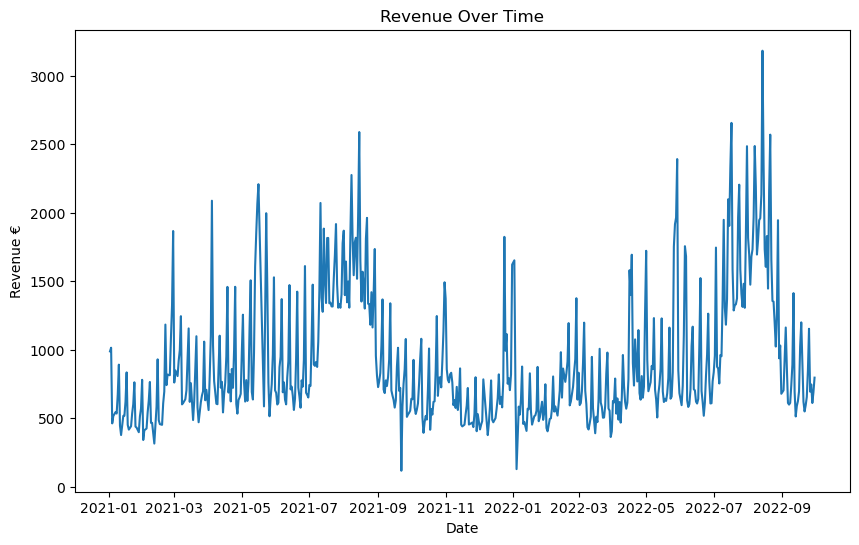

In [55]:
plt.figure(figsize=(10,6))
sns.lineplot(data=sales_over_time, x='date', y='revenue')
plt.title('Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue €')
plt.show()

The periods with the highest revenue are the summer months peaking in July and August.

### Sales by Month

In [56]:
sales_by_month = sales_data.groupby('month')['revenue'].sum().reset_index()
sales_by_month

,month,revenue
0,2021-01,15271.67
1,2021-02,16843.15
2,2021-03,20091.35
3,2021-04,24669.05
4,2021-05,29629.10
5,2021-06,24628.85
6,2021-07,42224.85
7,2021-08,48697.05
8,2021-09,22728.80
9,2021-10,22709.65


In [57]:
sales_by_month['month'] = sales_by_month['month'].dt.strftime('%b %Y')

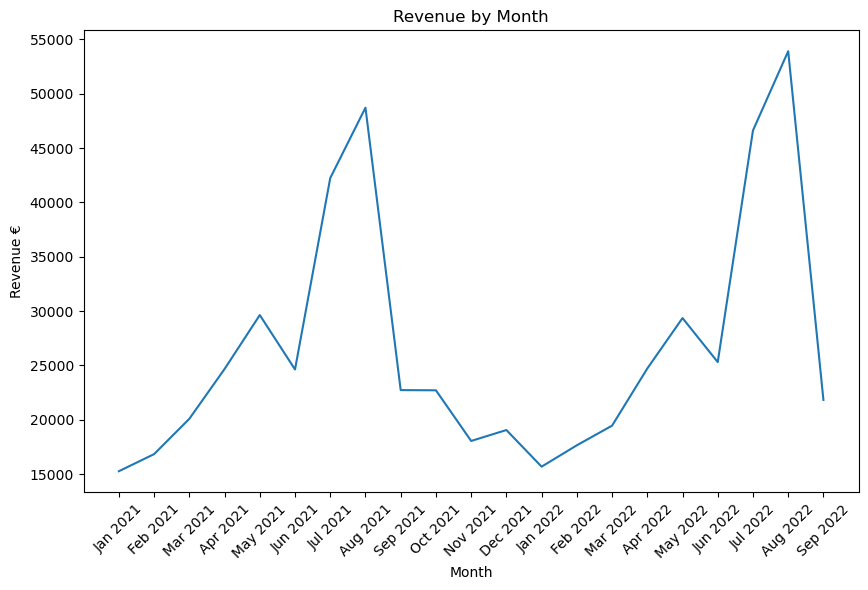

In [58]:
plt.figure(figsize=(10,6))
sns.lineplot(data=sales_by_month, x='month', y='revenue')
plt.title('Revenue by Month')
plt.xlabel('Month')
plt.ylabel('Revenue €')
plt.xticks(rotation=45)
plt.show()

We can observe that the total revenue per moth of both 2021 and 2022 have a very similar pattern with two peaks in sales, one in April and May, and the biggest one in July and August. The months with the lowest revenue are the winter months, with the lowest sales registered in January.

There is an increase in the revenue from 2021 to 2022, the highest revenue per month registered in 2021 was in August of **€48,697.05** and in 2022 the highest revenue registered was **€53,888.80**.

### Sales by Day of Week

In [59]:
sales_data['day_of_week'] = sales_data['date'].dt.dayofweek

day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
             4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

sales_data['day_name'] = sales_data['day_of_week'].map(day_names)

In [60]:
sales_over_time = sales_data.groupby('date')['revenue'].sum()
avg_daily_revenue = sales_over_time.groupby(sales_over_time.index.day_name()).mean().reset_index()
avg_daily_revenue

,date,revenue
0,Friday,847.971648
1,Monday,841.171023
2,Saturday,1041.934667
3,Sunday,1388.363516
4,Thursday,789.417191
5,Tuesday,757.004494
6,Wednesday,809.058871


In [61]:
avg_daily_revenue['date'] = pd.Categorical(avg_daily_revenue['date'], 
                                          categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                                                      'Friday', 'Saturday', 'Sunday'], 
                                          ordered=True)
avg_daily_revenue = avg_daily_revenue.sort_values('date')

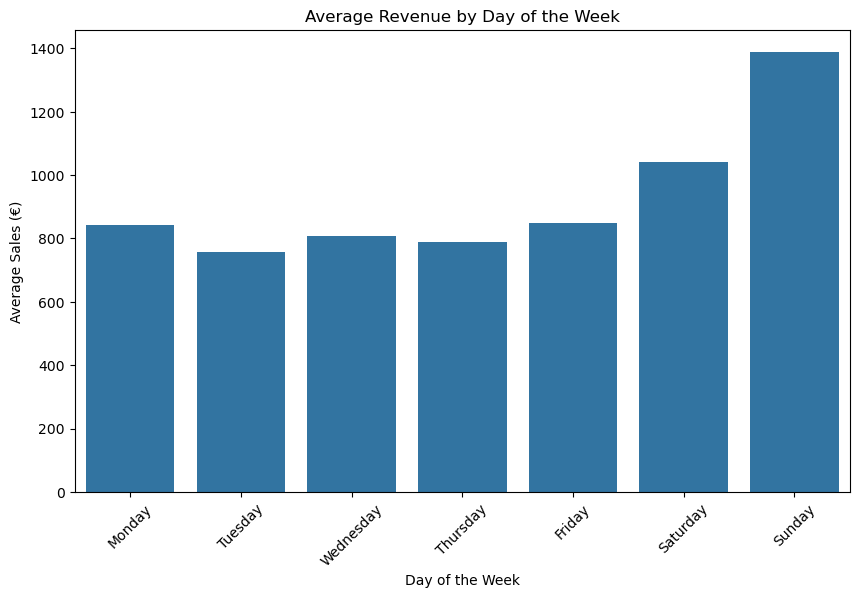

In [62]:
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_daily_revenue, x='date', y='revenue')
plt.title('Average Revenue by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales (€)')
plt.xticks(rotation=45)
plt.show()

**The revenue on weekdays is fairly similar for each day and it increases on the weekend, peaking on Sundays.**

## Sales by hour of the day

In [63]:
sales_data['hour'] = sales_data['datetime'].dt.floor('h')
sales_data.head()

,date,time,ticket_number,article,quantity,unit_price,datetime,revenue,month,day_of_week,day_name,hour
0,2021-01-02,0 days 08:38:00,150040.0,BAGUETTE,1.0,0.90,2021-01-02 08:38:00,0.90,2021-01,5,Saturday,2021-01-02 08:00:00
1,2021-01-02,0 days 08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,1.20,2021-01-02 08:38:00,3.60,2021-01,5,Saturday,2021-01-02 08:00:00
2,2021-01-02,0 days 09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,1.20,2021-01-02 09:14:00,2.40,2021-01,5,Saturday,2021-01-02 09:00:00
3,2021-01-02,0 days 09:14:00,150041.0,PAIN,1.0,1.15,2021-01-02 09:14:00,1.15,2021-01,5,Saturday,2021-01-02 09:00:00
4,2021-01-02,0 days 09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,2021-01-02 09:25:00,6.00,2021-01,5,Saturday,2021-01-02 09:00:00


In [64]:
sales_over_time = sales_data.groupby('hour')['revenue'].sum()
avg_sales_by_hour = sales_over_time.groupby(sales_over_time.index.hour).mean().reset_index()
avg_sales_by_hour

,hour,revenue
0,7,36.062900
1,8,113.462876
2,9,134.744983
3,10,159.449246
4,11,186.586555
5,12,168.808696
6,13,43.244587
7,14,11.553704
8,15,4.565957
9,16,45.238500


In [65]:
sales_over_time.head()

hour
2021-01-02 08:00:00      4.50
2021-01-02 09:00:00     86.35
2021-01-02 10:00:00    166.40
2021-01-02 11:00:00    253.80
2021-01-02 12:00:00    363.30
Name: revenue, dtype: float64

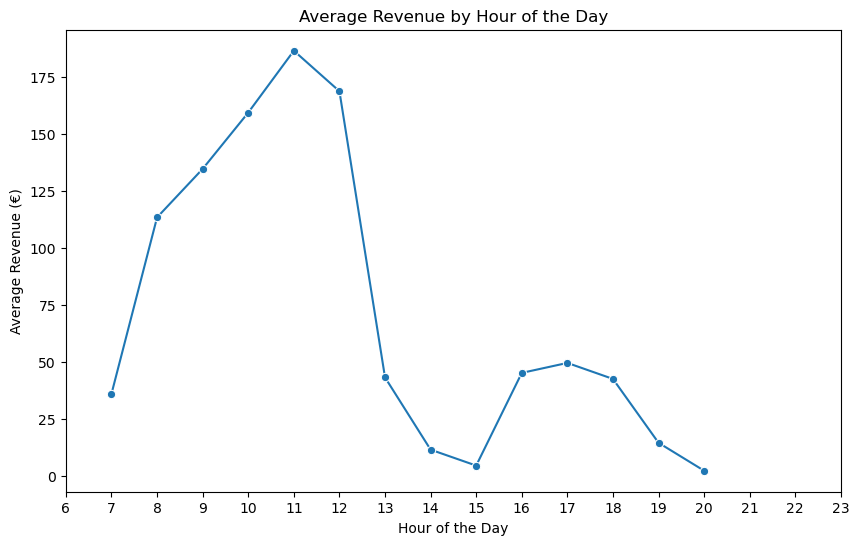

In [66]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_sales_by_hour, x='hour', y='revenue', marker='o')
plt.title('Average Revenue by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Revenue (€)')
plt.xticks(range(6, 24))
plt.show()

**The highest revenue is generated during the day, peaking at 11am with an average revenue €159.45**. The sales are lower during the evening.

## Best selling products

In [67]:
sales_by_product = sales_data.groupby('article').agg({
    'revenue': 'sum',
    'quantity': 'sum'
}).reset_index().set_index('article').sort_values(by='revenue', ascending=False)
total_revenue = sales_data['revenue'].sum()
sales_by_product['revenue_contribution'] = (sales_by_product['revenue'] / total_revenue) * 100

### Top 10 best selling products

In [68]:
sales_by_product.head(10)

,revenue,quantity,revenue_contribution
article,,,
TRADITIONAL BAGUETTE,144795.20,117495.0,25.898053
FORMULE SANDWICH,34936.50,5214.0,6.248738
CROISSANT,33602.10,29674.0,6.010068
PAIN AU CHOCOLAT,31121.40,25253.0,5.566370
BANETTE,24560.45,22737.0,4.392879
BAGUETTE,20488.95,22061.0,3.664651
SANDWICH COMPLET,13559.50,2890.0,2.425251
SPECIAL BREAD,13422.20,5457.0,2.400693
TRAITEUR,12269.50,1457.0,2.194521


In [69]:
top_10 = sales_by_product.head(10)

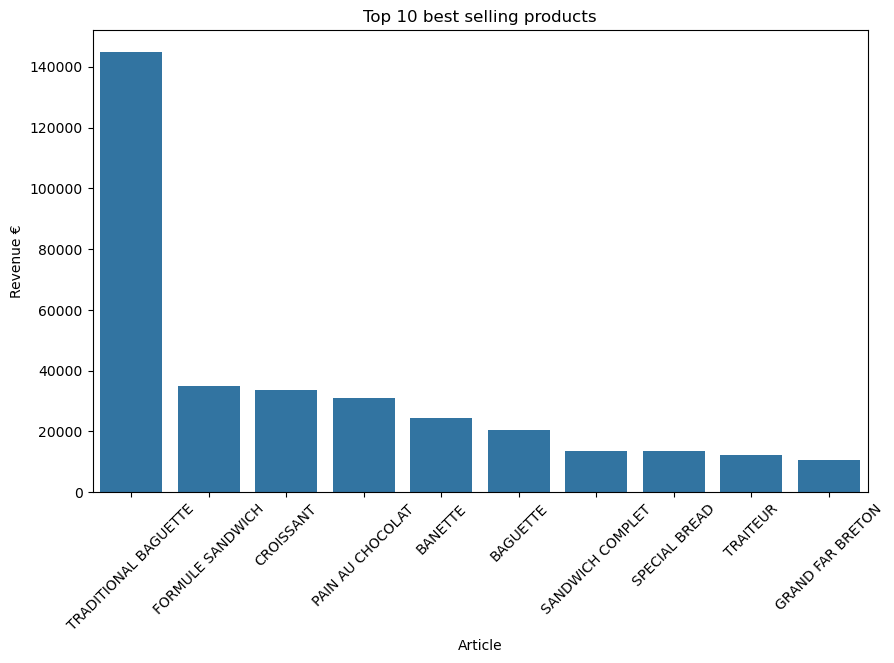

In [70]:
plt.figure(figsize=(10,6))
sns.barplot(data=top_10, x='article', y='revenue',)
plt.title('Top 10 best selling products')
plt.xlabel('Article')
plt.ylabel('Revenue €')
plt.xticks(rotation=45)
plt.show()

By seeing the top 10 best selling products, it's clear that the "Traditional Baguette" is by far the best selling product generating a total revenue of 144795.20, followed by the "Formule Sandwich" with a total revenue of 34710.50 Euros.

## Top products by quantity sold

### Top 10 products by quantity sold

In [71]:
top_ten_quantity = sales_by_product.quantity.to_frame().sort_values(by='quantity', ascending=False).head(10)
top_ten_quantity

,quantity
article,
TRADITIONAL BAGUETTE,117495.0
CROISSANT,29674.0
PAIN AU CHOCOLAT,25253.0
COUPE,23509.0
BANETTE,22737.0
BAGUETTE,22061.0
CEREAL BAGUETTE,7436.0
SPECIAL BREAD,5457.0
FORMULE SANDWICH,5214.0


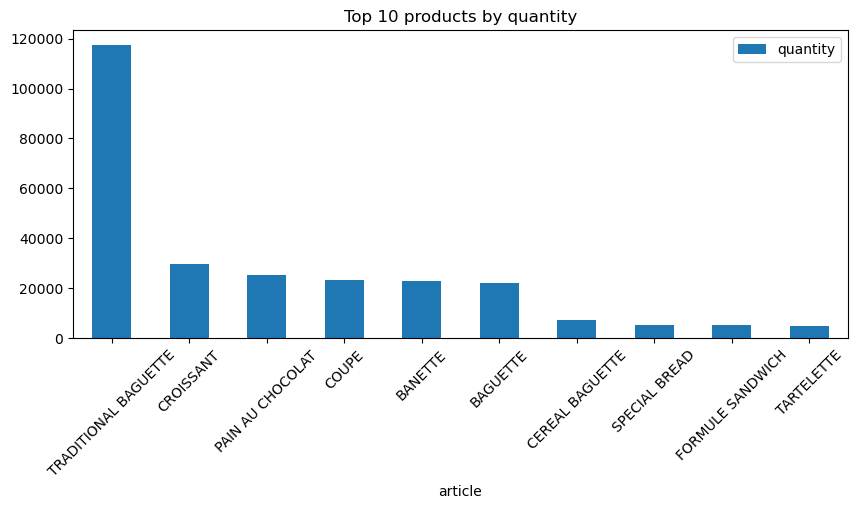

In [72]:
top_ten_quantity.plot(kind="bar", figsize=(10,4),title="Top 10 products by quantity", rot=45)
plt.show()

When it comes to quantity sold, "Traditional Baguettes" is still on top with 117,463 units sold, followed by the "Croissant" with 29,654 units.
The formule sandwich sits behind with a total of 5214.0 units sold, while still being the second product with the highest revenue, one of the reason for this is that the Formule Sandwich is sold at a higher price because of its high production costs, since it consists of a big sandwich, a soda can and a small dessert.

## Low-Performing Products

In [73]:
lowest_sales = sales_by_product.sort_values(by='revenue')

In [74]:
lowest_sales.head(20)

,revenue,quantity,revenue_contribution
article,,,
ARTICLE 295,0.0,1.0,0.000000
.,0.0,7.0,0.000000
PAIN NOIR,0.6,1.0,0.000107
DOUCEUR D HIVER,3.0,1.0,0.000537
CAKE,3.0,1.0,0.000537
TROIS CHOCOLAT,3.0,1.0,0.000537
SACHET DE VIENNOISERIE,4.0,1.0,0.000715
"PLATPREPARE6,00",6.0,1.0,0.001073
TARTELETTE COCKTAIL,6.0,2.0,0.001073


In [75]:
lowest_quantity = sales_by_product.quantity.to_frame().sort_values(by='quantity')

In [76]:
lowest_quantity.head(20)

,quantity
article,
TROIS CHOCOLAT,1.0
PAIN NOIR,1.0
ARTICLE 295,1.0
SACHET DE VIENNOISERIE,1.0
"PLATPREPARE6,00",1.0
DOUCEUR D HIVER,1.0
CAKE,1.0
REDUCTION SUCREES 24,1.0
GD PLATEAU SALE,2.0


**These product generate very small revenues and are sold in very small amounts, it should be considered to discontinuing this products or try to offer clients discounts for them. Also clients can be asked for their opinion about these product, which can help to gain insights to the bakery on why these products have very poor sales.**

# Analyzing best selling products

In [77]:
best_selling_names = sales_by_product.head(5).index.to_list()
best_selling_names

['TRADITIONAL BAGUETTE',
 'FORMULE SANDWICH',
 'CROISSANT',
 'PAIN AU CHOCOLAT',
 'BANETTE']

Getting sales data of only the five best performing products.

In [78]:
best_selling_data = sales_data[sales_data['article'].isin(best_selling_names)]
best_selling_data

,date,time,ticket_number,article,quantity,unit_price,datetime,revenue,month,day_of_week,day_name,hour
1,2021-01-02,0 days 08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,1.20,2021-01-02 08:38:00,3.60,2021-01,5,Saturday,2021-01-02 08:00:00
2,2021-01-02,0 days 09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,1.20,2021-01-02 09:14:00,2.40,2021-01,5,Saturday,2021-01-02 09:00:00
4,2021-01-02,0 days 09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,2021-01-02 09:25:00,6.00,2021-01,5,Saturday,2021-01-02 09:00:00
6,2021-01-02,0 days 09:25:00,150043.0,CROISSANT,3.0,1.10,2021-01-02 09:25:00,3.30,2021-01,5,Saturday,2021-01-02 09:00:00
7,2021-01-02,0 days 09:27:00,150044.0,BANETTE,1.0,1.05,2021-01-02 09:27:00,1.05,2021-01,5,Saturday,2021-01-02 09:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
233993,2022-09-30,0 days 18:26:00,288905.0,TRADITIONAL BAGUETTE,1.0,1.30,2022-09-30 18:26:00,1.30,2022-09,4,Friday,2022-09-30 18:00:00
233997,2022-09-30,0 days 18:39:00,288910.0,TRADITIONAL BAGUETTE,1.0,1.30,2022-09-30 18:39:00,1.30,2022-09,4,Friday,2022-09-30 18:00:00
233999,2022-09-30,0 days 18:52:00,288911.0,TRADITIONAL BAGUETTE,5.0,1.30,2022-09-30 18:52:00,6.50,2022-09,4,Friday,2022-09-30 18:00:00
234003,2022-09-30,0 days 18:55:00,288912.0,TRADITIONAL BAGUETTE,1.0,1.30,2022-09-30 18:55:00,1.30,2022-09,4,Friday,2022-09-30 18:00:00


### Sales by month

In [79]:
best_selling_month = best_selling_data.groupby(['month','article']).agg({
    'quantity': 'sum',
    'revenue': 'sum'
}).reset_index()
best_selling_month

,month,article,quantity,revenue
0,2021-01,BANETTE,649.0,681.45
1,2021-01,CROISSANT,786.0,864.60
2,2021-01,FORMULE SANDWICH,134.0,871.00
3,2021-01,PAIN AU CHOCOLAT,613.0,735.60
4,2021-01,TRADITIONAL BAGUETTE,2751.0,3301.20
...,...,...,...,...
100,2022-09,BANETTE,806.0,926.90
101,2022-09,CROISSANT,1080.0,1296.00
102,2022-09,FORMULE SANDWICH,197.0,1379.00
103,2022-09,PAIN AU CHOCOLAT,928.0,1206.40


In [80]:
best_selling_month['month'] = best_selling_month['month'].dt.strftime('%b %Y')

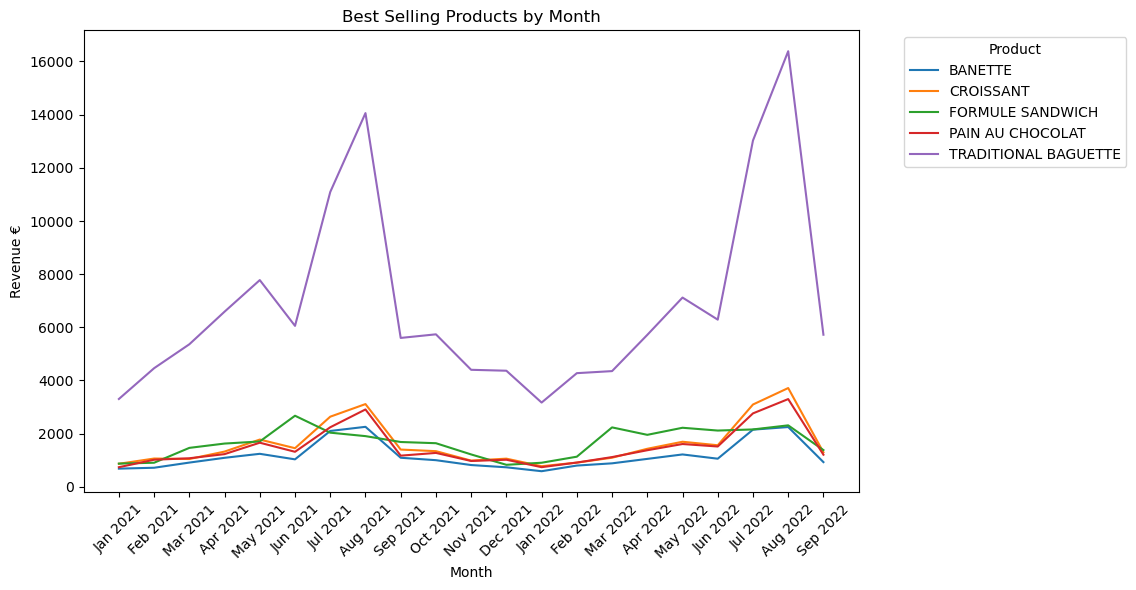

In [81]:
plt.figure(figsize=(10,6))
sns.lineplot(data=best_selling_month, x='month', y='revenue', hue='article')
plt.title('Best Selling Products by Month')
plt.xlabel('Month')
plt.ylabel('Revenue €')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

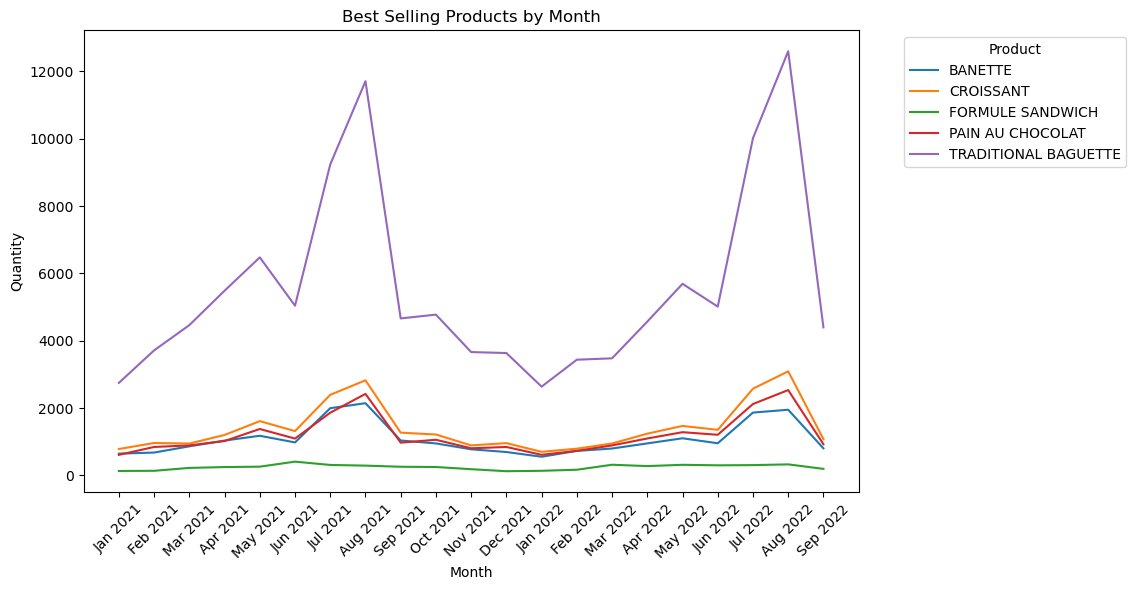

In [82]:
plt.figure(figsize=(10,6))
sns.lineplot(data=best_selling_month, x='month', y='quantity', hue='article')
plt.title('Best Selling Products by Month')
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

**Looking at the sales by month of the five best selling products, we can observe that the sales of all these products increase during the French summer except for the Formule Sandwich, which increase in sales starts at the end of the winter.**

### Average revenue generated by the best selling products by day

In [83]:
sales_over_time = best_selling_data.groupby(['date', 'article']).agg({
    'revenue': 'sum',
    'quantity': 'sum'
})
sales_over_time

revenue  quantity
date       article                                
2021-01-02 BANETTE                 42.00      40.0
           CROISSANT               72.60      66.0
           PAIN AU CHOCOLAT        57.60      48.0
           TRADITIONAL BAGUETTE   153.60     128.0
2021-01-03 BANETTE                 36.75      35.0
...                                  ...       ...
2022-09-30 BANETTE                 34.50      30.0
           CROISSANT               45.60      38.0
           FORMULE SANDWICH        63.00       9.0
           PAIN AU CHOCOLAT        41.60      32.0
           TRADITIONAL BAGUETTE   183.30     141.0

[2940 rows x 2 columns]

In [84]:
daily_avg_revenue_prod = sales_over_time.groupby([sales_over_time.index.get_level_values(0).day_name(), 'article']).agg({
    'revenue': 'mean',
    'quantity': 'mean'
}).reset_index()
daily_avg_revenue_prod

,date,article,revenue,quantity
0,Friday,BANETTE,36.296703,33.582418
1,Friday,CROISSANT,42.370879,37.373626
2,Friday,FORMULE SANDWICH,71.755556,10.722222
3,Friday,PAIN AU CHOCOLAT,45.480220,36.890110
4,Friday,TRADITIONAL BAGUETTE,198.184615,160.901099
5,Monday,BANETTE,38.770455,35.863636
6,Monday,CROISSANT,45.520455,40.090909
7,Monday,FORMULE SANDWICH,75.856322,11.333333
8,Monday,PAIN AU CHOCOLAT,41.788068,33.829545
9,Monday,TRADITIONAL BAGUETTE,229.776136,186.329545


In [85]:
daily_avg_revenue_prod['date'] = pd.Categorical(daily_avg_revenue_prod['date'], 
                                          categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                                                      'Friday', 'Saturday', 'Sunday'], 
                                          ordered=True)
daily_avg_revenue_prod = daily_avg_revenue_prod.sort_values('date')

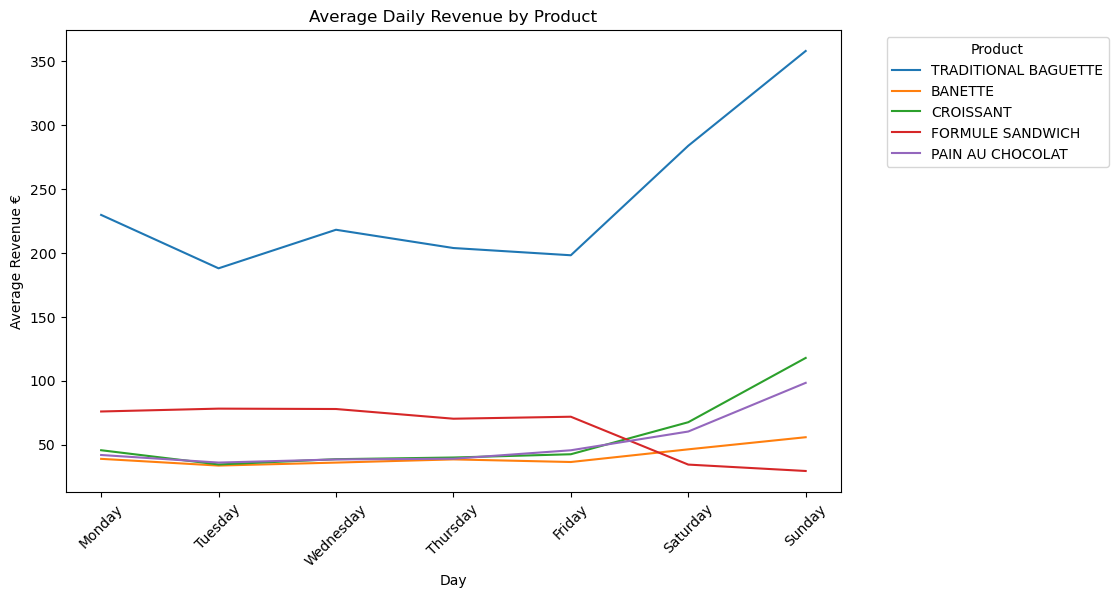

In [86]:
plt.figure(figsize=(10,6))
sns.lineplot(data=daily_avg_revenue_prod, x='date', y='revenue', hue='article')
plt.title('Average Daily Revenue by Product')
plt.xlabel('Day')
plt.ylabel('Average Revenue €')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

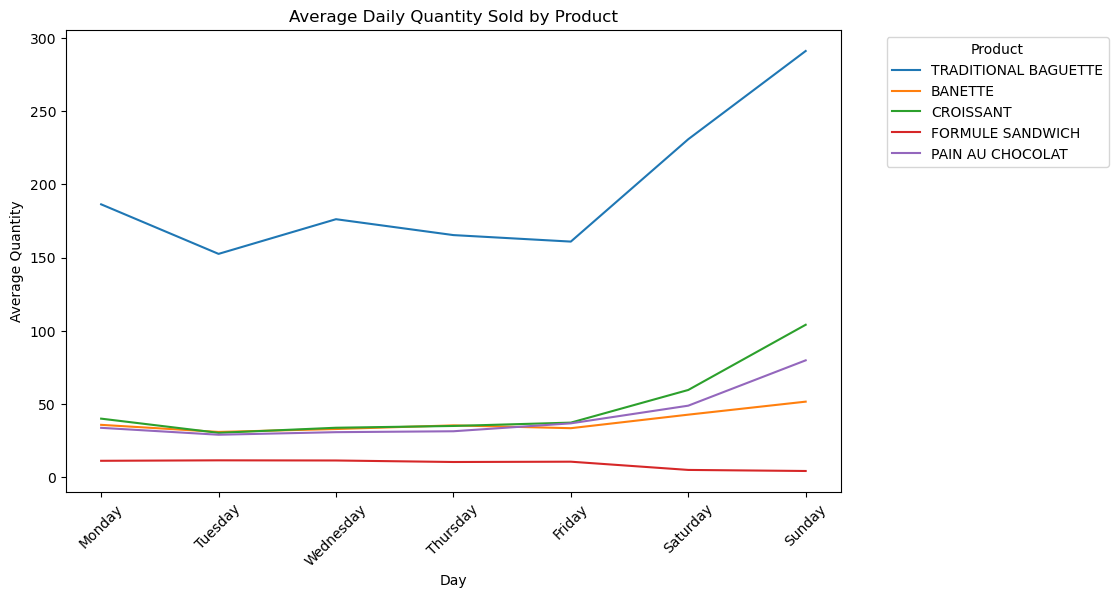

In [87]:
plt.figure(figsize=(10,6))
sns.lineplot(data=daily_avg_revenue_prod, x='date', y='quantity', hue='article')
plt.title('Average Daily Quantity Sold by Product')
plt.xlabel('Day')
plt.ylabel('Average Quantity')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

**The revenue and quantity sold of all products increase during the weekend, except for the Formule Sandwich. This is an indicator that the Formule Sandwich is a product consumed mainly during weekdays by people during their work breaks or students.**

### Best Selling Products: Revenue and Quantity Sold by Hour

In [88]:
sales_by_hour = best_selling_data.groupby(['hour', 'article']).agg({
    'revenue': 'sum',
    'quantity': 'sum'
})

In [89]:
products_avg_sales_hour = sales_by_hour.groupby([sales_by_hour.index.get_level_values(0).hour, 'article']).agg({
    'revenue': 'mean',
    'quantity': 'mean'
}).reset_index()
products_avg_sales_hour

,hour,article,revenue,quantity
0,7,BANETTE,2.959722,2.702381
1,7,CROISSANT,9.164444,8.032099
2,7,FORMULE SANDWICH,8.357143,1.253968
3,7,PAIN AU CHOCOLAT,8.186817,6.622328
4,7,TRADITIONAL BAGUETTE,7.410047,5.967290
...,...,...,...,...
60,19,CROISSANT,2.442308,2.153846
61,19,FORMULE SANDWICH,32.500000,5.000000
62,19,PAIN AU CHOCOLAT,1.920588,1.588235
63,19,TRADITIONAL BAGUETTE,5.784615,4.769231


In [90]:
products_avg_sales_hour[products_avg_sales_hour['article'] == 'FORMULE SANDWICH']

,hour,article,revenue,quantity
2,7,FORMULE SANDWICH,8.357143,1.253968
7,8,FORMULE SANDWICH,10.136943,1.515924
12,9,FORMULE SANDWICH,11.731429,1.748571
17,10,FORMULE SANDWICH,13.281095,1.975124
22,11,FORMULE SANDWICH,18.268041,2.708763
27,12,FORMULE SANDWICH,35.840426,5.338298
32,13,FORMULE SANDWICH,18.753846,2.861538
37,14,FORMULE SANDWICH,12.133333,1.866667
41,15,FORMULE SANDWICH,6.750000,1.000000
46,16,FORMULE SANDWICH,9.250000,1.375000


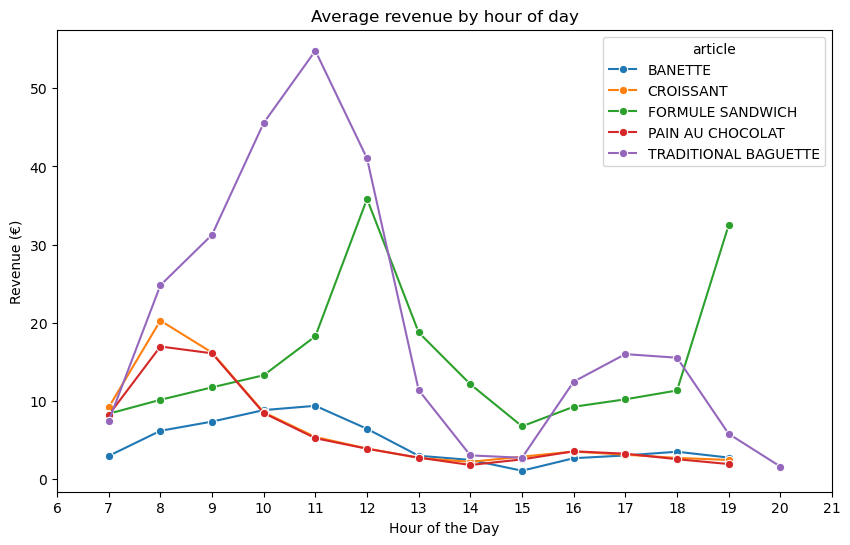

In [91]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=products_avg_sales_hour, x='hour', y='revenue', marker='o', hue='article')
plt.title('Average revenue by hour of day')
plt.xlabel('Hour of the Day')
plt.ylabel('Revenue (€)')
plt.xticks(range(6, 22))
plt.show()

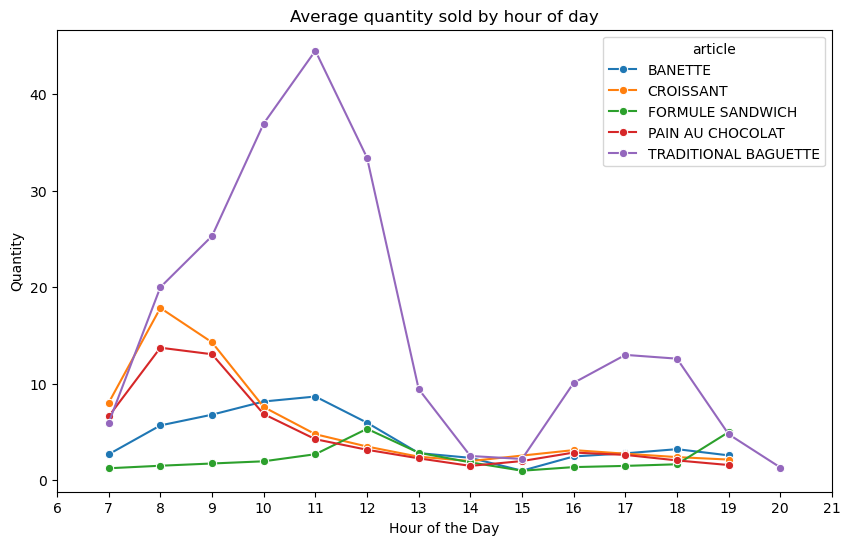

In [92]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=products_avg_sales_hour, x='hour', y='quantity', marker='o', hue='article')
plt.title('Average quantity sold by hour of day')
plt.xlabel('Hour of the Day')
plt.ylabel('Quantity')
plt.xticks(range(6, 22))
plt.show()

Early in the morning, the most popular products, apart from the Traditional Baguette, are the **Croissant** and **Pain Au Chocolat**. This indicates that people buy these products for breakfast, the sales of these two products peak during these hours and then decrease during the rest of the day.

**Traditional Baguette** sells the most during the day too, and reaches its peak sales at 11am with an average revenue of 54.8 Euros and an average quantity sold of 44.5.

The **Formule Sandwich** has peak sales in two different parts of the day, which matches when people have their lunch break from work, and leave work. Its sales start increasing during the morning and they peak at 12pm with generating an average revenue of 35.8 Euros and an average quantity sold of 5.3, and then its sales peak again in the evening at 7pm generating an average revenue of 32.5 Euros. This confirms that the **Formule Sandwich** is a product mainly bought by workers and students.  

## Analyzing Transactions

In [93]:
transaction_behavior = sales_data.groupby('ticket_number').agg({
    'quantity': 'sum',  
    'revenue': 'sum'
}).rename(columns={'quantity': 'total_items', 'revenue': 'transaction_value'}).reset_index()

transaction_behavior.head()

,ticket_number,total_items,transaction_value
0,150040.0,4.0,4.50
1,150041.0,3.0,3.55
2,150042.0,5.0,6.00
3,150043.0,5.0,5.10
4,150044.0,1.0,1.05


#### Statistical summary of transactions

In [94]:
transaction_behavior.describe()

,ticket_number,total_items,transaction_value
count,134962.000000,134962.000000,134962.000000
mean,219328.223826,2.668588,4.142624
std,40119.859775,2.303218,4.412152
min,150040.000000,1.000000,0.000000
25%,184608.250000,1.000000,1.300000
50%,218924.500000,2.000000,2.550000
75%,254241.750000,3.000000,5.100000
max,288913.000000,87.000000,199.700000


The average number of items per transaction is around 2.67, 3 if we round the number. The average transaction value is of 4.14 Euros.

The minimum and maximum number of items per transaction is of 1 and 87, and the minimum and maximum transaction value is of 0 and 199.7. Let's take a closer look on these transactions.

In [95]:
transaction_behavior[transaction_behavior['transaction_value'] == 199.7]

,ticket_number,total_items,transaction_value
43198,194199.0,23.0,199.7


In [96]:
sales_data[sales_data['ticket_number'] == 194199.0]

,date,time,ticket_number,article,quantity,unit_price,datetime,revenue,month,day_of_week,day_name,hour
74998,2021-07-31,0 days 12:32:00,194199.0,GRAND FAR BRETON,1.0,7.0,2021-07-31 12:32:00,7.0,2021-07,5,Saturday,2021-07-31 12:00:00
74999,2021-07-31,0 days 12:32:00,194199.0,GD NANTAIS,11.0,11.0,2021-07-31 12:32:00,121.0,2021-07,5,Saturday,2021-07-31 12:00:00
75000,2021-07-31,0 days 12:32:00,194199.0,GD KOUIGN AMANN,9.0,7.5,2021-07-31 12:32:00,67.5,2021-07,5,Saturday,2021-07-31 12:00:00
75001,2021-07-31,0 days 12:32:00,194199.0,KOUIGN AMANN,2.0,2.1,2021-07-31 12:32:00,4.2,2021-07,5,Saturday,2021-07-31 12:00:00


**This transaction contains expensive products like "GD Nantais" and "GD Kouign Amann" with unit prices of 11 and 7.5 Euros, and in this transaction the customer bought 11 GD Nantais and 9 GD Kouign Amann. All of the products in these transactions are pastries, we can see that they are bought in big quantity and size so this may be a customer organizing an event.**

#### Transaction with a value of 0

In [97]:
transaction_behavior[transaction_behavior['transaction_value'] == 0]

,ticket_number,total_items,transaction_value
6115,156355.0,1.0,0.0


In [98]:
sales_data[sales_data['ticket_number'] == 156355.0]

,date,time,ticket_number,article,quantity,unit_price,datetime,revenue,month,day_of_week,day_name,hour
10373,2021-02-19,0 days 10:13:00,156355.0,DIVERS BOULANGERIE,1.0,0.0,2021-02-19 10:13:00,0.0,2021-02,4,Friday,2021-02-19 10:00:00


There is a transaction with a unit price of 0 Euros, let's explore more about the "Divers Boulangerie" article.

In [99]:
sales_data[sales_data['article'] == 'DIVERS BOULANGERIE']

,date,time,ticket_number,article,quantity,unit_price,datetime,revenue,month,day_of_week,day_name,hour
774,2021-01-04,0 days 10:03:00,150465.0,DIVERS BOULANGERIE,1.0,2.00,2021-01-04 10:03:00,2.00,2021-01,0,Monday,2021-01-04 10:00:00
1236,2021-01-07,0 days 11:28:00,150785.0,DIVERS BOULANGERIE,1.0,12.00,2021-01-07 11:28:00,12.00,2021-01,3,Thursday,2021-01-07 11:00:00
1906,2021-01-09,0 days 19:54:00,151206.0,DIVERS BOULANGERIE,1.0,1.00,2021-01-09 19:54:00,1.00,2021-01,5,Saturday,2021-01-09 19:00:00
1921,2021-01-10,0 days 09:03:00,151213.0,DIVERS BOULANGERIE,1.0,1.00,2021-01-10 09:03:00,1.00,2021-01,6,Sunday,2021-01-10 09:00:00
2063,2021-01-10,0 days 11:54:00,151291.0,DIVERS BOULANGERIE,1.0,1.00,2021-01-10 11:54:00,1.00,2021-01,6,Sunday,2021-01-10 11:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
231590,2022-09-23,0 days 17:00:00,287419.0,DIVERS BOULANGERIE,1.0,1.00,2022-09-23 17:00:00,1.00,2022-09,4,Friday,2022-09-23 17:00:00
231703,2022-09-24,0 days 09:26:00,287479.0,DIVERS BOULANGERIE,1.0,1.00,2022-09-24 09:26:00,1.00,2022-09,5,Saturday,2022-09-24 09:00:00
233236,2022-09-28,0 days 11:33:00,288420.0,DIVERS BOULANGERIE,1.0,0.25,2022-09-28 11:33:00,0.25,2022-09,2,Wednesday,2022-09-28 11:00:00
233334,2022-09-28,0 days 17:10:00,288487.0,DIVERS BOULANGERIE,1.0,6.00,2022-09-28 17:10:00,6.00,2022-09,2,Wednesday,2022-09-28 17:00:00


**As we can observe, the unit prices of this article vary. Knowing that "Divers Boulangerie" means "Various Bakery", we can assume that these are generic articles.**

#### Transaction with 87 articles

In [100]:
transaction_behavior[transaction_behavior['total_items'] == 87]

,ticket_number,total_items,transaction_value
68117,219600.0,87.0,81.95


In [101]:
sales_data[sales_data['ticket_number'] == 219600.0]

,date,time,ticket_number,article,quantity,unit_price,datetime,revenue,month,day_of_week,day_name,hour
118312,2021-11-08,0 days 10:03:00,219600.0,CROISSANT,1.0,1.10,2021-11-08 10:03:00,1.10,2021-11,0,Monday,2021-11-08 10:00:00
118313,2021-11-08,0 days 10:03:00,219600.0,CAMPAGNE,21.0,1.80,2021-11-08 10:03:00,37.80,2021-11,0,Monday,2021-11-08 10:00:00
118314,2021-11-08,0 days 10:03:00,219600.0,COUPE,21.0,0.15,2021-11-08 10:03:00,3.15,2021-11,0,Monday,2021-11-08 10:00:00
118315,2021-11-08,0 days 10:03:00,219600.0,BAGUETTE,43.0,0.90,2021-11-08 10:03:00,38.70,2021-11,0,Monday,2021-11-08 10:00:00
118316,2021-11-08,0 days 10:03:00,219600.0,PAIN AU CHOCOLAT,1.0,1.20,2021-11-08 10:03:00,1.20,2021-11,0,Monday,2021-11-08 10:00:00


Again, this may the case of a customer buying big amounts of products for an event. The article named "Coupe" is not a product but when the customer asks for his bread to be sliced. In this case we can see that the customer bought 21 of "Campagne" and also we see 21 "Coupe", so he asked for the 21 "Campagne" breads he bought to be sliced.

## Most Popular Product Combinations

Market Basket Analysis will be performed to identify products that are frequently bought together, using the Apriori Algorithm.

In [102]:
transactions = sales_data.groupby('ticket_number')['article'].apply(list)
transaction_list = transactions.tolist()

In [103]:
te = TransactionEncoder()
te_array = te.fit(transaction_list).transform(transaction_list)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

In [104]:
frequent_itemsets = apriori(df_encoded, min_support=0.02, use_colnames=True)

In [105]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules_sorted = rules.sort_values(by="lift", ascending=False)

In [106]:
print(rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

          antecedents         consequents   support  confidence      lift
6         (CROISSANT)  (PAIN AU CHOCOLAT)  0.039619    0.471725  6.101679
7  (PAIN AU CHOCOLAT)         (CROISSANT)  0.039619    0.512459  6.101679
2          (CAMPAGNE)             (COUPE)  0.022955    0.800103  5.604294
3             (COUPE)          (CAMPAGNE)  0.022955    0.160785  5.604294
0        (BOULE 400G)             (COUPE)  0.023770    0.794846  5.567472
1             (COUPE)        (BOULE 400G)  0.023770    0.166494  5.567472
5             (COUPE)     (SPECIAL BREAD)  0.022391    0.156840  4.133468
4     (SPECIAL BREAD)             (COUPE)  0.022391    0.590119  4.133468


#### Explanation of the columns

- **Support**: Measures how frequently an itemset appears in the dataset.
- **Confidence**:  Measures how often B is bought when A is bought.
- **Lift**: Measures how much more likely A and B are bought together than if they were independent.

We can observe that the combination with the highest lift, which means that they are more likely to be bought together, is the one of the **Croissant** and **Pain Au Chocolat** with a **lift of 6.10**. There is a **confidence level of 0.47** for this combination, which means that when **a Croissant is purchased 47% of the time a Pain Au Chocolat is also bought**.

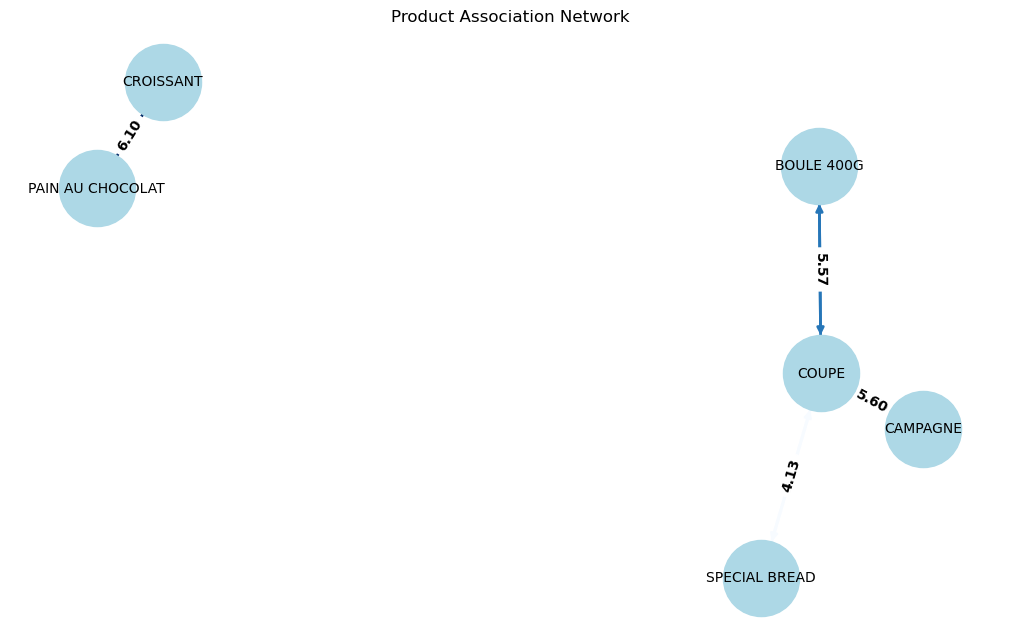

In [107]:
G = nx.DiGraph()

for _, rule in rules.iterrows():
    G.add_edge(', '.join(rule['antecedents']), ', '.join(rule['consequents']), weight=rule['lift'])

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, k=1.0)
edges = G.edges(data=True)

edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}

weights = [edata['weight'] for _, _, edata in edges]

nx.draw(G, pos, with_labels=True, edge_color=weights, width=2, edge_cmap=plt.cm.Blues, node_color='lightblue', node_size=3000, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color="black", font_weight="bold")

plt.title("Product Association Network")
plt.show()

There are other popular combinations, the ones of **Boule**, **Campagne**, and **Special Bread**. These are associated with **Coupe**, Coupe is when a customer asks for his bread to be sliced so these combinations make sense. Boule and Campagne are big rounded breads in some cases with a hard crust, and customers prefer to ask the baker to slice the bread for them instead for doing it themselves at home.